In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Note: we can't actually use pandas in our algorithm, but we can use it to read in our df

binary recursive partitioning. This is an iterative process of splitting the data into partitions, and then splitting it up further on each of the branches.

https://towardsdatascience.com/decision-tree-classification-de64fc4d5aac

https://towardsdatascience.com/what-is-a-decision-tree-22975f00f3e1

### Quantifying splits with impurity
https://victorzhou.com/blog/gini-impurity/

"Gini Impurity is the probability of incorrectly classifying a randomly chosen element in the dataset if it were randomly labeled according to the class distribution in the dataset."

Decision Tree Classifier
Using the decision algorithm, **we start at the tree root and split the data on the feature that results in the largest information gain (IG)** (reduction in uncertainty towards the final decision).
In an iterative process, we can then repeat this splitting procedure at each child node **until the leaves are pure**. This means that the samples at each leaf node all belong to the same class.
In practice, we may **set a limit on the depth of the tree** to prevent overfitting. We compromise on purity here somewhat as the final leaves may still have some impurity.


In [3]:
import pandas as pd
df = pd.read_csv('Iris.csv')

In [4]:
df.drop(columns='Id', inplace=True)

In [5]:
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Train/test split 

In [70]:
def train_test_split(df, test_size):
    
    # get a list of indices
    indices = df.index.to_list()
    
    # if a float result, rounding test_size to an int is needed
    test_size = round(test_size * len(df))
    
    # get a random choice of the indices
    test_indices = np.random.default_rng().choice(indices, size=test_size)

    # create our test df
    test = df.loc[test_indices]
        
    # create our train df 
    train = df.drop(test_indices)
    
    # return both
    return train, test

In [71]:
# see if percentages work 
train, test = train_test_split(df, 0.22)

In [72]:
train.shape, test.shape

((118, 5), (33, 5))

In [73]:
# numpy array 
train_data = train.values
train_data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [4.6, 3.4, 1.4, 0.3, 'Iris-setosa']], dtype=object)

## Check purity

In [74]:
def purity(data):
    # pass in 2d array
    data = ???
    return False

SyntaxError: invalid syntax (<ipython-input-74-617bc4916d9e>, line 3)

In [75]:
# [np.unique(labels)[2]] * len(labels)

### Classify

In [76]:
def classify(data):
    
    # get the true labels for the input data
    labels = data[:,-1]
    
    # get the unique labels and label counts for this input data
    classes, class_counts = np.unique(labels, return_counts=True)
    
    # get the majority class
    index = class_counts.argmax()
    
    # classify our input as the majority
    classification = classes[index]
    
    return classification

In [77]:
classify(train[train.PetalWidthCm > 1.2].values)

'Iris-virginica'

### Potential splits

In [219]:
train.tail()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
143,6.8,3.2,5.9,2.3,Iris-virginica
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [220]:
def get_potential_splits(data):
    
    potential_splits = {}

    # how many columns are there
    _, n_columns = train_data.shape
    
    # for each column in our array 
    for column_index in range(n_columns - 1):
    
        # we want our key to be the column index
        potential_splits[column_index] = []
    
        # we want our value to be each row value at that index
        values = train_data[:, column_index]
    
        # we want all the possible splits
        unique_values = np.unique(values)

        # for each index in range(15)
        for index in range(len(unique_values)):

            if index != 0:

                # get the sum of the current and previous values and 
                current_value = unique_values[index]
                previous_value = unique_values[index-1]
                potential_split = (current_value + previous_value) / 2

                potential_splits[column_index].append(potential_split)
    
    return potential_splits

In [221]:
potential_splits = get_potential_splits(train_data)

In [222]:
# one for each column besides the label
potential_splits.keys()

dict_keys([0, 1, 2, 3])

In [223]:
import seaborn as sns

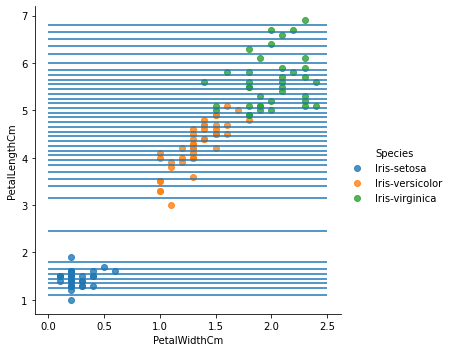

In [224]:
sns.lmplot(data=train, x='PetalWidthCm', y='PetalLengthCm', hue='Species', fit_reg=False)
plt.hlines(y=potential_splits[2], xmin=0, xmax=2.5);

### Split data

In [225]:
train_data[:5]

array([[5.1, 3.5, 1.4, 0.2, 'Iris-setosa'],
       [4.9, 3.0, 1.4, 0.2, 'Iris-setosa'],
       [4.7, 3.2, 1.3, 0.2, 'Iris-setosa'],
       [4.6, 3.1, 1.5, 0.2, 'Iris-setosa'],
       [4.6, 3.4, 1.4, 0.3, 'Iris-setosa']], dtype=object)

In [282]:
# which question is most important?
# ex. "is the petal width less/larger than value"
# we have four questions to ask it

# split dataset based on column and value
def split_data(data, split_col, split_val):
    
    # get that specific column's values
    split_column_values = data[:, split_col]
    
    # get the data below the specified value 
    data_below = data[split_column_values <= split_val]
    
    # get the data above the specified value
    data_above = data[split_column_values > split_val]
    
    return data_below, data_above

In [307]:
split_col = 2
split_val = 2.45

In [308]:
# Question: is our petal width < or > 0.8?
data_below, data_above = split_data(train_data, split_col, split_val)

In [309]:
data_above

array([[7.0, 3.2, 4.7, 1.4, 'Iris-versicolor'],
       [6.9, 3.1, 4.9, 1.5, 'Iris-versicolor'],
       [5.5, 2.3, 4.0, 1.3, 'Iris-versicolor'],
       [6.5, 2.8, 4.6, 1.5, 'Iris-versicolor'],
       [5.7, 2.8, 4.5, 1.3, 'Iris-versicolor'],
       [6.3, 3.3, 4.7, 1.6, 'Iris-versicolor'],
       [4.9, 2.4, 3.3, 1.0, 'Iris-versicolor'],
       [6.6, 2.9, 4.6, 1.3, 'Iris-versicolor'],
       [5.0, 2.0, 3.5, 1.0, 'Iris-versicolor'],
       [5.9, 3.0, 4.2, 1.5, 'Iris-versicolor'],
       [6.0, 2.2, 4.0, 1.0, 'Iris-versicolor'],
       [6.1, 2.9, 4.7, 1.4, 'Iris-versicolor'],
       [5.6, 2.9, 3.6, 1.3, 'Iris-versicolor'],
       [6.7, 3.1, 4.4, 1.4, 'Iris-versicolor'],
       [5.6, 3.0, 4.5, 1.5, 'Iris-versicolor'],
       [5.8, 2.7, 4.1, 1.0, 'Iris-versicolor'],
       [6.2, 2.2, 4.5, 1.5, 'Iris-versicolor'],
       [5.6, 2.5, 3.9, 1.1, 'Iris-versicolor'],
       [5.9, 3.2, 4.8, 1.8, 'Iris-versicolor'],
       [6.1, 2.8, 4.0, 1.3, 'Iris-versicolor'],
       [6.3, 2.5, 4.9, 1.5, 'Iris-versic

Steps to calculate entropy for a split:

Calculate entropy of parent node
Calculate entropy of each individual node of split and calculate weighted average of all sub-nodes available in split.

entropy = sum(probs * -log2(probs))

In [310]:
 def calculate_entropy(data):
        
    labels = data[:,-1]
    _, counts = np.unique(labels, return_counts=True)

    probs = counts / counts.sum()

    entropy = sum(probs * -np.log2(probs))
    return entropy

In [311]:
data_above

array([[7.0, 3.2, 4.7, 1.4, 'Iris-versicolor'],
       [6.9, 3.1, 4.9, 1.5, 'Iris-versicolor'],
       [5.5, 2.3, 4.0, 1.3, 'Iris-versicolor'],
       [6.5, 2.8, 4.6, 1.5, 'Iris-versicolor'],
       [5.7, 2.8, 4.5, 1.3, 'Iris-versicolor'],
       [6.3, 3.3, 4.7, 1.6, 'Iris-versicolor'],
       [4.9, 2.4, 3.3, 1.0, 'Iris-versicolor'],
       [6.6, 2.9, 4.6, 1.3, 'Iris-versicolor'],
       [5.0, 2.0, 3.5, 1.0, 'Iris-versicolor'],
       [5.9, 3.0, 4.2, 1.5, 'Iris-versicolor'],
       [6.0, 2.2, 4.0, 1.0, 'Iris-versicolor'],
       [6.1, 2.9, 4.7, 1.4, 'Iris-versicolor'],
       [5.6, 2.9, 3.6, 1.3, 'Iris-versicolor'],
       [6.7, 3.1, 4.4, 1.4, 'Iris-versicolor'],
       [5.6, 3.0, 4.5, 1.5, 'Iris-versicolor'],
       [5.8, 2.7, 4.1, 1.0, 'Iris-versicolor'],
       [6.2, 2.2, 4.5, 1.5, 'Iris-versicolor'],
       [5.6, 2.5, 3.9, 1.1, 'Iris-versicolor'],
       [5.9, 3.2, 4.8, 1.8, 'Iris-versicolor'],
       [6.1, 2.8, 4.0, 1.3, 'Iris-versicolor'],
       [6.3, 2.5, 4.9, 1.5, 'Iris-versic

In [312]:
calculate_entropy(data_below)

0.0

In [313]:
def calculate_overall_entropy(data_below, data_above):
    
    total_data_points = len(data_below) + len(data_above)
    
    # weight of data below
    p_of_data_below = len(data_below) / total_data_points
    
    # weight of data above
    p_of_data_above = len(data_above) / total_data_points
    
    overall_entropy = (p_of_data_below * calculate_entropy(data_below))+(p_of_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [314]:
calculate_overall_entropy(data_below, data_above)

0.6922290478625892

In [317]:
potential_splits = get_potential_splits(train_data)

In [322]:
def find_best_split(data, potential_splits):
    
    '''Figure out where the best split is for given data'''
    
    # set entropy to abritrary high number
    overall_entropy = 500
    
    # for each dictionary key (0,1,2,3)
    for column_index in potential_splits:
        
        # for each value within that key
        for value in potential_splits[column_index]:
            
            # split the data 
            data_below, data_above = split_data(train_data, split_col=column_index, split_val=value)
            
            # calculate the entropy
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy < overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    
    
    return best_split_column, best_split_value

In [323]:
find_best_split(train_data, potential_splits)

(2, 2.45)

In [320]:
best_split_column

2